In [10]:
%load_ext autoreload
%autoreload 2

#  https://mapreader.readthedocs.io/en/latest/Install.html
import os, sys
sys.path.append('../scripts/')
import mapreader
from mapreader import PatchDataset
import cartopy
from torchvision import models
from torch import nn

### Load .tif

In [3]:
# load map tif paths
from mapreader import loader
my_files = loader("../content/tifs/masked/*.tif")
my_files.add_geo_info() # if pre georeferenced may need to set: target_crs 
print(my_files)

  0%|          | 0/1 [00:00<?, ?it/s]

#images: 1

#parents: 1
SK1468_combined.tif

#patches: 0



In [8]:
#my_files.parents["SK1070_combined.tif"]["shape"]

In [8]:
# not needed now 3 bands
#parent_list = my_files.list_parents()
#for parent in parent_list:
#    my_files.parents[parent]["shape"] = (*my_files.parents[parent]["shape"], 1)

### Patchify

In [11]:
# set directory & patch size (pixels unless -- method="meters" )
my_files.patchify_all(path_save="../content/tifs/patches/", patch_size=25)
#my_files.save_patches_as_geotiffs(crs='EPSG:27700')

[INFO] Saving patches in directory named "../content/tifs/patches/".


  0%|          | 0/1 [00:00<?, ?it/s]

../content/tifs/masked/SK1468_combined.tif


In [12]:
parent_list = my_files.list_parents()
patch_list = my_files.list_patches()

print(parent_list)
print(patch_list[0:5])  # too many to print them all!

['SK1468_combined.tif']
['patch-0-0-25-25-#SK1468_combined.tif#.png', 'patch-0-25-25-50-#SK1468_combined.tif#.png', 'patch-0-50-25-75-#SK1468_combined.tif#.png', 'patch-0-75-25-100-#SK1468_combined.tif#.png', 'patch-0-100-25-125-#SK1468_combined.tif#.png']


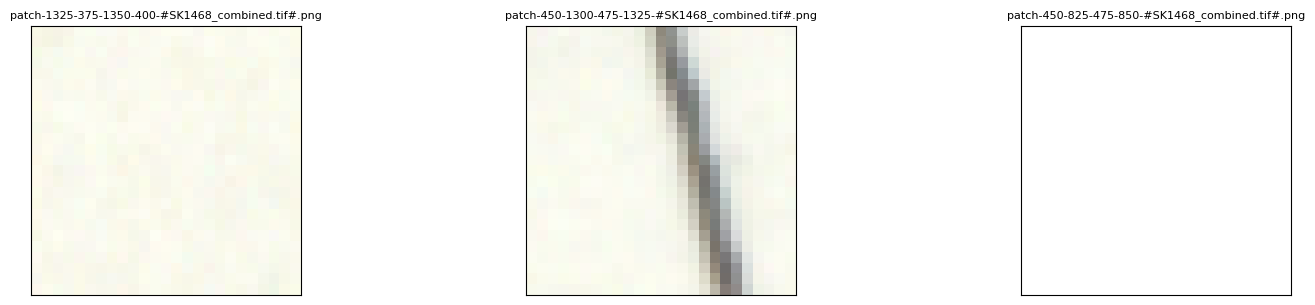

In [10]:
my_files.show_sample(num_samples=3, tree_level="patch")

  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 1 Axes>]

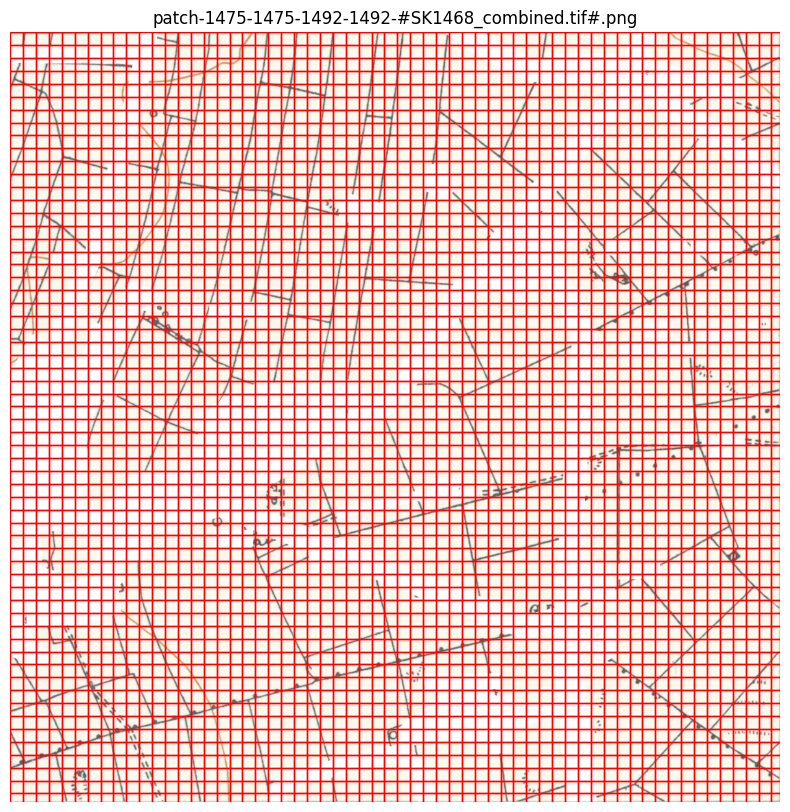

In [13]:
# show patches
parent_list = my_files.list_parents()
my_files.show_parent(parent_list[0])

In [16]:
my_files.calc_pixel_stats()
parent_df, patch_df = my_files.convert_images()
parent_df["url"]="fake_url"

  0%|          | 0/1 [00:00<?, ?it/s]

### Annotate

In [17]:
from mapreader import Annotator

annotator = Annotator(
    patch_df=patch_df,
    parent_df=parent_df,
    task_name="walls",
    labels=["no_wall", "wall"],
    annotations_dir = "../content/annotations_1950/",
    username="DavidA",
    show_context=True,
)

annotator.annotate(resize_to=300, show_context=True, surrounding=3) #to resize up the tiny patch, you might also want show_context=False as its confusing

[INFO] Loading existing patch annotations.


Output(layout=Layout(align_items='center', display='flex', flex_flow='column'))

In [ ]:
# load annotations file


In [18]:
# save annotations
annotator.annotations_file

'../content/annotations_1950/walls_#DavidA#-abef7f4982ea7e9624cd5f4dc899cae4.csv'

### Perpare train

In [19]:
# Load and check annotations 

import pandas as pd

df = pd.read_csv(annotator.annotations_file, index_col=0)
df["image_id"]=df.index

from mapreader import AnnotationsLoader

annotated_images = AnnotationsLoader()
annotated_images.load(annotations=df)

[INFO] Number of annotations:   304

[INFO] Number of instances of each label (from column "label"):
    - no_wall:  231
    - wall:  73



In [20]:
# view the data
annotated_images.annotations

,image_path,label,image_id,label_index
image_id,,,,
patch-0-1175-25-1200-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-0-1175-25-1200-#SK1468_combined.tif#.png,0
patch-0-1475-25-1492-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-0-1475-25-1492-#SK1468_combined.tif#.png,0
patch-0-275-25-300-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,wall,patch-0-275-25-300-#SK1468_combined.tif#.png,1
patch-0-350-25-375-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-0-350-25-375-#SK1468_combined.tif#.png,0
patch-0-375-25-400-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-0-375-25-400-#SK1468_combined.tif#.png,0
...,...,...,...,...
patch-975-475-1000-500-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-975-475-1000-500-#SK1468_combined.tif#.png,0
patch-975-675-1000-700-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-975-675-1000-700-#SK1468_combined.tif#.png,0
patch-975-725-1000-750-#SK1468_combined.tif#.png,/home/david/Documents/GitHub/cnn-boundaries/co...,no_wall,patch-975-725-1000-750-#SK1468_combined.tif#.png,0


In [21]:
# label map
annotated_images.labels_map

{0: 'no_wall', 1: 'wall'}

In [22]:
# Prepare datasets and dataloaders
dataloaders = annotated_images.create_dataloaders()

[INFO] Creating datasets using default train/val/test split of 0.7:0.15:0.15 and default transformations.
[INFO] Number of annotations in each set:
    - train:   212
    - val:   46
    - test:   46
[INFO] Using default sampler.


### Train

In [23]:
from mapreader import ClassifierContainer
my_classifier = ClassifierContainer("resnet18", annotated_images.labels_map, dataloaders)

[INFO] Device is set to cuda:0
[INFO] Initializing model.
[INFO] Loaded "train" with 212 items.
[INFO] Loaded "val" with 46 items.
[INFO] Loaded "test" with 46 items.


In [24]:
# loss function
my_classifier.add_criterion("cross-entropy")

[INFO] Using "CrossEntropyLoss()" as criterion.


In [25]:
# optimizer 
my_classifier.initialize_optimizer()

In [26]:
# scheduler
my_classifier.initialize_scheduler()

In [35]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [28]:
import tensorflow as tf
print("GPU Name:", tf.test.gpu_device_name())
print("GPU Memory Growth:", tf.config.experimental.get_memory_growth(tf.config.list_physical_devices('GPU')[0]))

GPU Name: /device:GPU:0
GPU Memory Growth: True


2024-02-12 22:10:13.378451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 22:10:13.378608: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-12 22:10:13.378703: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [29]:
import torch
assert torch.cuda.is_available()

In [30]:
# train with default 25 epochs
my_classifier.train()

[INFO] Each step will pass: ['train', 'val'].
2024-02-12 22:10:19 pop-os [INFO] train    -- 1/25 --     16/212 (  7.5% ) -- Loss: 0.639
2024-02-12 22:10:20 pop-os [INFO] train    -- 1/25 --     96/212 ( 45.3% ) -- Loss: 0.930
2024-02-12 22:10:20 pop-os [INFO] train    -- 1/25 --    176/212 ( 83.0% ) -- Loss: 0.385
2024-02-12 22:10:20 pop-os [INFO] train    -- 1/25 -- Loss: 0.431; F_macro: 85.38; R_macro: 85.38
2024-02-12 22:10:20 pop-os [INFO] val      -- 1/25 --      16/46 ( 34.8% ) -- Loss: 33.093
2024-02-12 22:10:20 pop-os [INFO] val      -- 1/25 -- Loss: 28.712; F_macro: 19.30; R_macro: 50.00

2024-02-12 22:10:20 pop-os [INFO] train    -- 2/25 --     16/212 (  7.5% ) -- Loss: 0.212
2024-02-12 22:10:20 pop-os [INFO] train    -- 2/25 --     96/212 ( 45.3% ) -- Loss: 0.449
2024-02-12 22:10:20 pop-os [INFO] train    -- 2/25 --    176/212 ( 83.0% ) -- Loss: 0.104
2024-02-12 22:10:20 pop-os [INFO] train    -- 2/25 -- Loss: 0.437; F_macro: 83.18; R_macro: 83.63
2024-02-12 22:10:20 pop-os 

### Plot metrics

In [32]:
list(my_classifier.metrics.keys())

['epoch_loss_train',
 'epoch_prec_micro_train',
 'epoch_recall_micro_train',
 'epoch_fscore_micro_train',
 'epoch_supp_micro_train',
 'epoch_rocauc_micro_train',
 'epoch_prec_macro_train',
 'epoch_recall_macro_train',
 'epoch_fscore_macro_train',
 'epoch_supp_macro_train',
 'epoch_rocauc_macro_train',
 'epoch_prec_weighted_train',
 'epoch_recall_weighted_train',
 'epoch_fscore_weighted_train',
 'epoch_supp_weighted_train',
 'epoch_rocauc_weighted_train',
 'epoch_prec_0_train',
 'epoch_recall_0_train',
 'epoch_fscore_0_train',
 'epoch_supp_0_train',
 'epoch_prec_1_train',
 'epoch_recall_1_train',
 'epoch_fscore_1_train',
 'epoch_supp_1_train',
 'epoch_loss_val',
 'epoch_prec_micro_val',
 'epoch_recall_micro_val',
 'epoch_fscore_micro_val',
 'epoch_supp_micro_val',
 'epoch_rocauc_micro_val',
 'epoch_prec_macro_val',
 'epoch_recall_macro_val',
 'epoch_fscore_macro_val',
 'epoch_supp_macro_val',
 'epoch_rocauc_macro_val',
 'epoch_prec_weighted_val',
 'epoch_recall_weighted_val',
 'epoch_fs

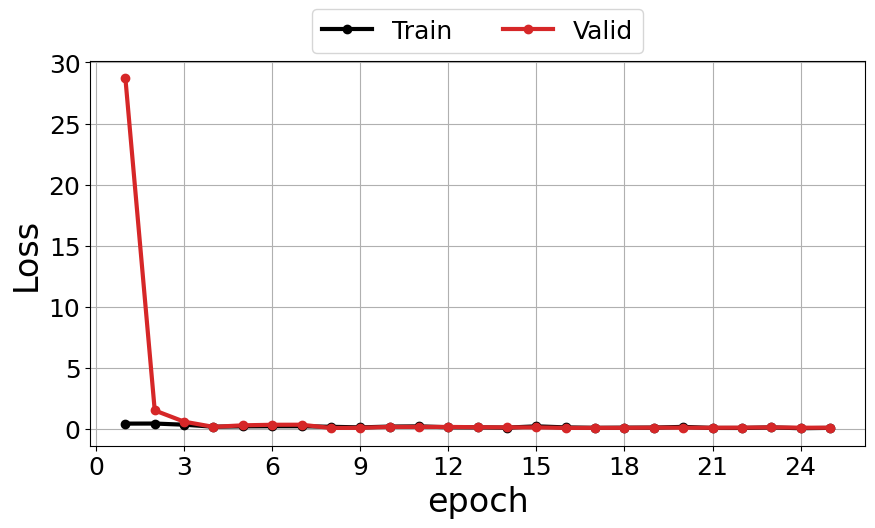

In [33]:
# loss per epoch of training and validation
my_classifier.plot_metric(
    y_axis=["epoch_loss_train", "epoch_loss_val"],
    y_label="Loss",
    legends=["Train", "Valid"],
)

### Testing

In [37]:
my_classifier.inference(set_name="test")

[INFO] Each step will pass: ['test'].


OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 0 has a total capacity of 7.72 GiB of which 54.44 MiB is free. Process 3027 has 5.23 GiB memory in use. Including non-PyTorch memory, this process has 1.29 GiB memory in use. Of the allocated memory 1.06 GiB is allocated by PyTorch, and 54.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

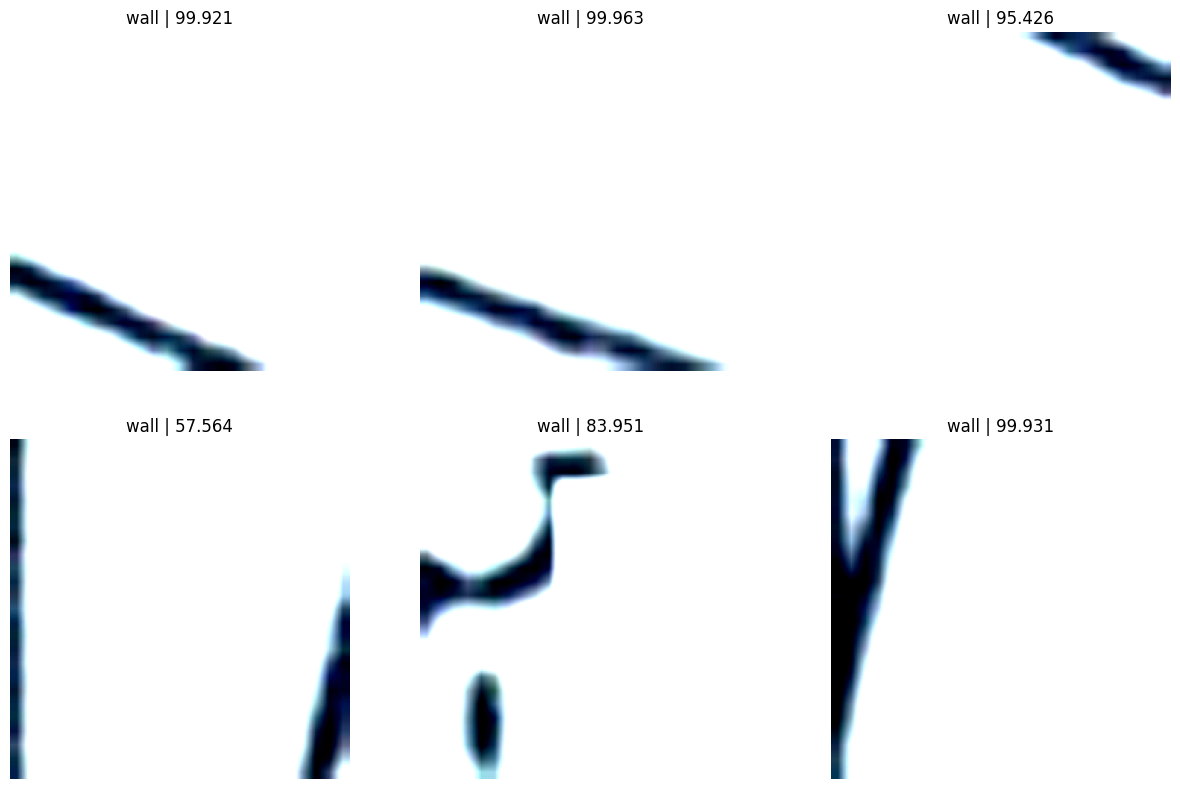

In [23]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall")

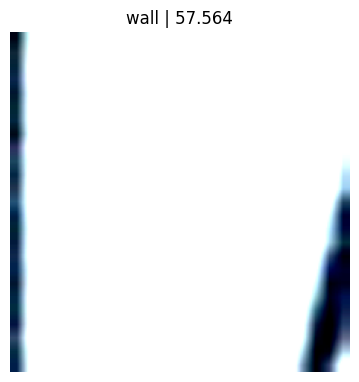

In [24]:
# prediction sample
my_classifier.show_inference_sample_results(label="wall", max_conf=80)

In [35]:
my_classifier.calculate_add_metrics(
    y_true=my_classifier.orig_label,
    y_pred=my_classifier.pred_label,
    y_score=my_classifier.pred_conf,
    phase="test",
)

In [36]:
my_classifier.metrics["epoch_rocauc_macro_test"]

[2.885244448993527]

### Save

In [38]:
my_classifier.save("../notebooks/models/test_3.pkl")

### Model Inference

In [39]:
infer = PatchDataset("../content/annotations_1950/walls_#DavidA#-2c94c781a11c0ef2e67ed7e2fba3ad39.csv", delimiter=",", transform="test")

[INFO] Reading "../content/annotations_1950/walls_#DavidA#-2c94c781a11c0ef2e67ed7e2fba3ad39.csv".


In [40]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(infer, set_name="infer")

In [41]:
my_classifier.inference(set_name="infer")

[INFO] Each step will pass: ['infer'].
2024-02-02 13:54:25 PC05258 [INFO] infer    -- 26/26 --     16/330 (  4.8% ) -- 
2024-02-02 13:54:26 PC05258 [INFO] infer    -- 26/26 --     96/330 ( 29.1% ) -- 
2024-02-02 13:54:27 PC05258 [INFO] infer    -- 26/26 --    176/330 ( 53.3% ) -- 
2024-02-02 13:54:28 PC05258 [INFO] infer    -- 26/26 --    256/330 ( 77.6% ) -- 
2024-02-02 13:54:29 PC05258 [INFO] infer    -- 26/26 --    330/330 (100.0% ) -- 
[INFO] Total time: 0m 5s


### Add predictions to metadata and save

In [152]:
import numpy as np

infer.patch_df['predicted_label'] = my_classifier.pred_label
infer.patch_df['pred'] = my_classifier.pred_label_indices
infer.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

In [73]:
infer.patch_df

,image_id,image_path,label
0,patch-0-0-25-25-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
1,patch-0-100-25-125-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
2,patch-0-1000-25-1025-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
3,patch-0-1025-25-1050-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
4,patch-0-1050-25-1075-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
...,...,...,...
995,patch-75-875-100-900-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
996,patch-75-900-100-925-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
997,patch-75-925-100-950-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall
998,patch-75-950-100-975-#SK1070_combined.tif#.png,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,wall


0it [00:00, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/46800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

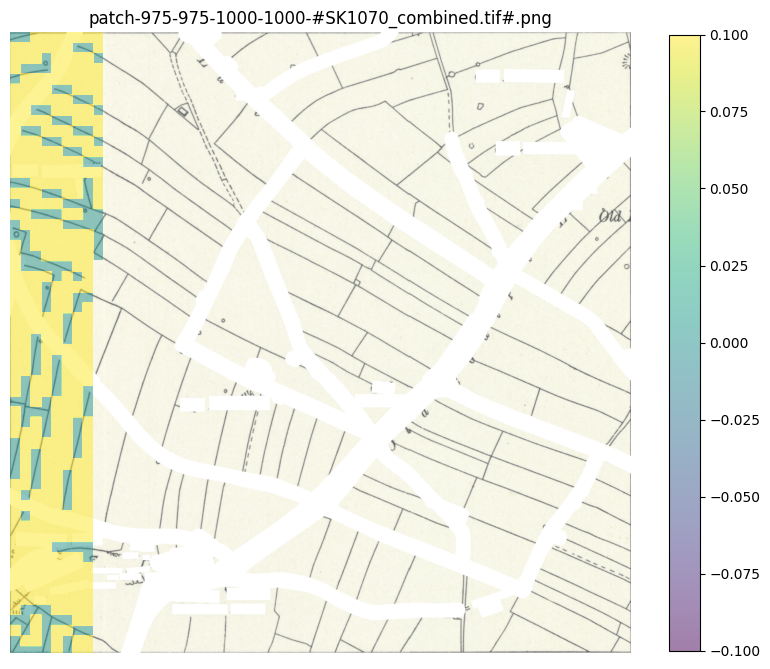

In [153]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*png", parent_paths="../content/tifs/masked/*.tif")

infer_df = infer.patch_df
my_maps.add_metadata(infer_df, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

### Full data test

In [20]:
patch_df.reset_index(inplace=True, drop=False)

In [21]:
patch_df.head()

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B
0,patch-0-0-25-25-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 0, 25, 25)","(-1.8516676236042906, 53.23577337869845, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2357733786984...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.832157,0.830482,0.789289,0.176909,0.173345,0.161569
1,patch-0-25-25-50-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 25, 25, 50)","(-1.8516676236042906, 53.2356229416401, -1.851...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2356229416401...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961293,0.953682,0.895755,0.039232,0.041379,0.037379
2,patch-0-50-25-75-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 50, 25, 75)","(-1.8516676236042906, 53.23547250458175, -1.85...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2354725045817...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.961092,0.955765,0.898704,0.040898,0.039841,0.035361
3,patch-0-75-25-100-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 75, 25, 100)","(-1.8516676236042906, 53.2353220675234, -1.851...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2353220675234...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.959128,0.953180,0.895216,0.041304,0.040486,0.035594
4,patch-0-100-25-125-#SK1070_combined.tif#.png,SK1070_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 25, 3)","(0, 100, 25, 125)","(-1.8516676236042906, 53.235171630465054, -1.8...",EPSG:4326,POLYGON ((-1.8514158144882014 53.2351716304650...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.882359,0.880345,0.830720,0.150095,0.147566,0.134672


In [42]:
predictions = PatchDataset(patch_df, transform="test")

In [43]:
predictions

In [44]:
# add this dataset to ClassifierContainer()
my_classifier.load_dataset(predictions, set_name="predictions")

In [45]:
my_classifier.inference(set_name="predictions")

[INFO] Each step will pass: ['predictions'].
2024-02-02 13:54:52 PC05258 [INFO] predictions -- 26/26 --   16/10800 (  0.1% ) -- 
2024-02-02 13:54:53 PC05258 [INFO] predictions -- 26/26 --   96/10800 (  0.9% ) -- 
2024-02-02 13:54:54 PC05258 [INFO] predictions -- 26/26 --  176/10800 (  1.6% ) -- 
2024-02-02 13:54:55 PC05258 [INFO] predictions -- 26/26 --  256/10800 (  2.4% ) -- 
2024-02-02 13:54:56 PC05258 [INFO] predictions -- 26/26 --  336/10800 (  3.1% ) -- 
2024-02-02 13:54:57 PC05258 [INFO] predictions -- 26/26 --  416/10800 (  3.9% ) -- 
2024-02-02 13:54:58 PC05258 [INFO] predictions -- 26/26 --  496/10800 (  4.6% ) -- 
2024-02-02 13:54:59 PC05258 [INFO] predictions -- 26/26 --  576/10800 (  5.3% ) -- 
2024-02-02 13:55:00 PC05258 [INFO] predictions -- 26/26 --  656/10800 (  6.1% ) -- 
2024-02-02 13:55:01 PC05258 [INFO] predictions -- 26/26 --  736/10800 (  6.8% ) -- 
2024-02-02 13:55:02 PC05258 [INFO] predictions -- 26/26 --  816/10800 (  7.6% ) -- 
2024-02-02 13:55:03 PC05258 [IN

In [46]:
import numpy as np

predictions.patch_df['predicted_label'] = my_classifier.pred_label
predictions.patch_df['pred'] = my_classifier.pred_label_indices
predictions.patch_df['conf'] = np.array(my_classifier.pred_conf).max(axis=1)

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10800 [00:00<?, ?it/s]

[INFO] Add shape, tree level: parent


  0%|          | 0/1 [00:00<?, ?it/s]

[<Figure size 1000x1000 with 2 Axes>]

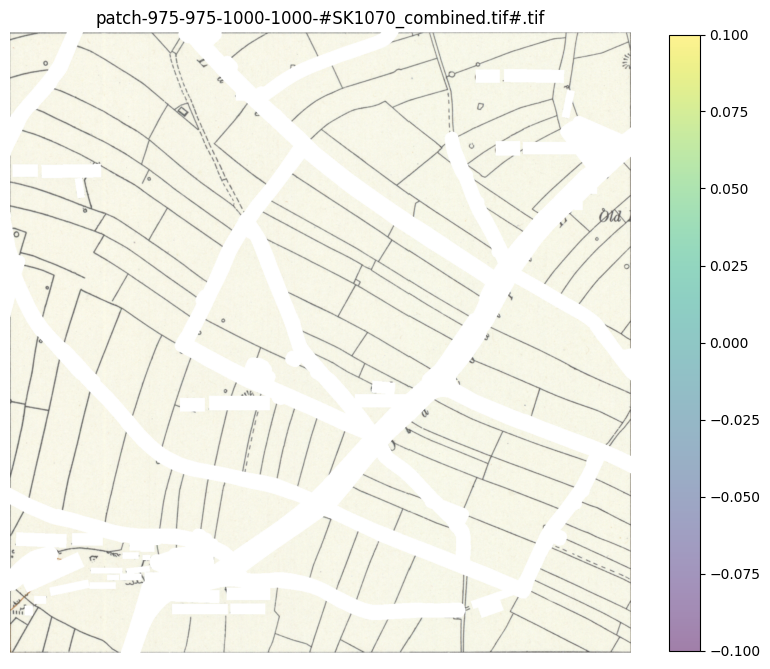

In [47]:
from mapreader import load_patches

my_maps = load_patches(patch_paths = "../content/tifs/patches/*tif", parent_paths="../content/tifs/masked/*.tif")

patch_df_predictions = predictions.patch_df
my_maps.add_metadata(patch_df_predictions, tree_level='patch', ignore_mismatch=True) # add dataframe as metadata
my_maps.add_shape()

parent_list = my_maps.list_parents()
my_maps.show_parent(parent_list[0], column_to_plot="pred", vmin=0, vmax=1, alpha=0.5, patch_border=False)

In [50]:
patch_df.tail(2)

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B,predicted_label,pred,conf
10798,patch-1475-1450-1492-1475-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 17, 3)","(1475, 1450, 1492, 1475)","(-1.7769374883964921, 53.21797246567226, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21797246567226...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.964734,0.964660,0.916632,0.041197,0.039213,0.041889,no_wall,1,0.992278
10799,patch-1475-1475-1492-1492-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(17, 17, 3)","(1475, 1475, 1492, 1492)","(-1.7769374883964921, 53.21787027512231, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21787027512231...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.946699,0.948938,0.903196,0.073276,0.071365,0.072475,wall,0,1.000000


In [58]:
patch_df_predictions.tail(2)

,image_id,parent_id,image_path,shape,pixel_bounds,coordinates,crs,polygon,geotiff_path,mean_pixel_R,mean_pixel_G,mean_pixel_B,std_pixel_R,std_pixel_G,std_pixel_B,predicted_label,pred,conf
10798,patch-1475-1450-1492-1475-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(25, 17, 3)","(1475, 1450, 1492, 1475)","(-1.7769374883964921, 53.21797246567226, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21797246567226...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.964734,0.964660,0.916632,0.041197,0.039213,0.041889,no_wall,1,0.992278
10799,patch-1475-1475-1492-1492-#SK1469_combined.tif...,SK1469_combined.tif,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,"(17, 17, 3)","(1475, 1475, 1492, 1492)","(-1.7769374883964921, 53.21787027512231, -1.77...",EPSG:4326,POLYGON ((-1.776766186711054 53.21787027512231...,c:\Users\alexad\Documents\GitHub\cnn-boundarie...,0.946699,0.948938,0.903196,0.073276,0.071365,0.072475,wall,0,1.000000


In [60]:
import geopandas as gpd

# change tuple columns to strings
for col in patch_df_predictions.columns:
    if isinstance(patch_df_predictions[col][0], tuple):
        patch_df_predictions[col] = patch_df_predictions[col].apply(str)

geo_patch_df = gpd.GeoDataFrame(patch_df_predictions, geometry="polygon", crs='EPSG:4326')
geo_patch_df.to_file("../content/predictions/patches.geojson", driver="GeoJSON")

In [47]:
patch_df_predictions.to_csv("../content/predictions/predictions_patch_df.csv", sep=",")